<a href="https://colab.research.google.com/github/sacktock/EDVAM-models/blob/main/LSTM_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LSTM classifier for the EDVAM dataset**

EDVAM: the first 3D eye tracking dataset for a virtual world.
https://github.com/YunzhanZHOU/EDVAM

Best configuration of parameters found (so far):
*   Original model - with 1 LSTM cell:
  *   12 input features
  *   hidden size = 12
  *   dropout = 0.4
  *   12 output classes
*   Hyper-parameters:
  *   batch size = 32
  *   learning rate = 0.1
  *   number of epochs = 30
  *   decay learning rate by a factor of 10 every 15 epochs
  *   stochactic gradient descent (SGD) optimizer
*   Other tricks:
  *   normalize entire dataset
  *   batch normalization
  *   stochastic frame sampling - 78 frames
  *   trainable initial state
  *   set forget gate biases to 1

Results: the (best) validation accuracy acheived with this model was 74.819%














**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Install Dependencies**

In [ ]:
!pip install livelossplot

**Imports**

In [3]:
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from livelossplot import PlotLosses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Hyper-params**


In [4]:
batch_size = 32
learning_rate = 0.1
n_epoch = 40

lr_halflife = 20. # learning rate decay in epochs
lr_decay_rate = .1**(1./lr_halflife) # decay by a factor of 10 after 20 epochs

**Import Dataset**

In [5]:
# fetch the training data and labels
train_set = np.load('drive/My Drive/EDVAM_practical_subset/train.npy')
train_set = np.delete(train_set, [10, 11] + [i for i in range(14,40)], axis=2)
train_label = np.load('drive/My Drive/EDVAM_practical_subset/train_label.npy')

# fetch the test data and labels
test_set = np.load('drive/My Drive/EDVAM_practical_subset/test.npy')
test_set = np.delete(test_set, [10, 11] + [i for i in range(14,40)], axis=2)
# split the test set into sequnces of 78 frames instead of 300
test_set = np.concatenate((test_set[:, 0:150:6 , :], test_set[:, 150:240:5, :], test_set[:, 240:290:2, :], test_set[:, 290:300, :]), axis=1)
test_label = np.load('drive/My Drive/EDVAM_practical_subset/test_label.npy')

# normalize both datasets using pre-computed means and stds
means = np.array([[[-14.37293346, 1.62620999 , -4.38974475, -16.22418695, 1.71081376, 
                    -4.03731866, 0.48303131, -0.04178857, -0.03728982, 0.55570785, 0.49841385, 0.55300117]]], dtype=np.float16)

stds = np.array([[[4.06166681, 0.86760783, 2.84685403, 2.68625898, 0.06159622, 1.63527627, 0.65958249, 
                   0.18040276, 0.55574791, 0.41272051, 0.23186055, 0.62825613]]], dtype=np.float16)

train_set = (train_set - means) / stds
test_set = (test_set - means) / stds

# wrap data in tensors and init data loaders
train_data = TensorDataset(torch.from_numpy(train_set), torch.from_numpy(train_label))
test_data = TensorDataset(torch.from_numpy(test_set), torch.from_numpy(test_label))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

dataloaders = {"train": train_loader, "test": test_loader}

**Looking at the Dataset**

In [5]:
# Visualizing the data
print('Train set size:', len(train_data))
print('Test set size:',len(test_data))
print()

print('Data item:')
print(train_data[1])
print()

print('Time window:',train_data[1][0])
print()
print('Label:',train_data[1][1])
print()

print('Time window shape', test_data[1][0].shape)
print()

print('Frame:', train_data[1][0][1])
print()
print('Frame shape', train_data[1][0][1].shape)

# Compute means and stds
arr = train_set.reshape(-1, train_set.shape[-1])
arr = arr.astype(np.float128)

print(arr.mean(axis=0))
print(arr.std(axis=0))

del arr

Train set size: 190830
Test set size: 32530

Data item:
(tensor([[-0.2269, -0.8369,  0.2072,  ..., -0.7651,  0.4761,  0.0287],
        [-0.2769,  0.3162, -0.1783,  ..., -0.7847,  0.2864, -0.0039],
        [-0.2769,  0.6606, -0.3196,  ..., -0.8384,  0.1074, -0.0497],
        ...,
        [-0.2769,  0.6606,  0.1015,  ...,  0.8774,  0.4592, -0.0870],
        [-0.2769,  0.6606,  0.1015,  ...,  0.8823,  0.4529, -0.0882],
        [-0.2769,  0.6606,  0.1015,  ...,  1.0762,  0.4443, -0.0925]],
       dtype=torch.float16), tensor(0., dtype=torch.float64))

Time window: tensor([[-0.2269, -0.8369,  0.2072,  ..., -0.7651,  0.4761,  0.0287],
        [-0.2769,  0.3162, -0.1783,  ..., -0.7847,  0.2864, -0.0039],
        [-0.2769,  0.6606, -0.3196,  ..., -0.8384,  0.1074, -0.0497],
        ...,
        [-0.2769,  0.6606,  0.1015,  ...,  0.8774,  0.4592, -0.0870],
        [-0.2769,  0.6606,  0.1015,  ...,  0.8823,  0.4529, -0.0882],
        [-0.2769,  0.6606,  0.1015,  ...,  1.0762,  0.4443, -0.0925]],

**Define the Model (original)**

In [6]:
class LSTMModel(nn.Module):

  def __init__(self, input_size, output_size, hidden_dim=12, dropout=0.4):
    super().__init__()    
    self.output_size = output_size
    self.hidden_dim = hidden_dim

    self.drop = nn.Dropout(dropout)
    self.lstm = nn.LSTMCell(input_size, hidden_dim)
    self.linear = nn.Linear(hidden_dim, output_size)


    self.init_weights()
    self.init_hidden()

  def init_weights(self):
    # init the weights of the linear classifier
    initrange = 0.1
    self.linear.bias.data.zero_()
    self.linear.weight.data.uniform_(-initrange, initrange)

    # set the forget gate bias to 1
    n = self.lstm.bias_hh.size(0)
    start, end = n//4, n//2
    self.lstm.bias_hh.data[start:end].fill_(1.)

    n = self.lstm.bias_ih.size(0)
    start, end = n//4, n//2
    self.lstm.bias_ih.data[start:end].fill_(1.)

  def init_hidden(self):
    # init the trainable initial hidden state
    h0 = torch.zeros(1, self.hidden_dim).to(device)
    c0 = torch.zeros(1, self.hidden_dim).to(device)
    nn.init.xavier_normal_(h0, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_normal_(c0, gain=nn.init.calculate_gain('relu'))
    self.h0 = nn.Parameter(h0, requires_grad=True) 
    self.c0 = nn.Parameter(c0, requires_grad=True)

  def forward(self, input):
    input = input.float()
    batch_size = input.shape[0]

    # initial hidden state 
    h_t, c_t = (self.h0.repeat(batch_size, 1), self.c0.repeat(batch_size, 1))

    for i, input in enumerate(input.chunk(input.size(1), dim=1)):
      h_t, c_t = self.lstm(input.squeeze(), (h_t, c_t))

    output = self.linear(self.drop(h_t))

    return output

input_size = 12
output_size = 12

model = LSTMModel(input_size, output_size).to(device)
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
liveplot = PlotLosses()

**Define the Model (new)**

In [6]:
class LSTMModel(nn.Module):

  def __init__(self, input_size, output_size, hidden_dim=20, num_layers=3, dropout=0):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.drop = nn.Dropout(dropout)
    self.lstm = nn.LSTM(self.input_size, self.hidden_dim, self.num_layers, dropout=dropout, batch_first=True)
    self.linear = nn.Linear(self.hidden_dim, self.output_size)

    self.init_weights()
    self.init_hidden()

  def init_weights(self):
    initrange = 0.1
    self.linear.bias.data.zero_()
    self.linear.weight.data.uniform_(-initrange, initrange)

    # set the forget gate bias to 1
    for names in self.lstm._all_weights:
      for name in filter(lambda n: "bias" in n,  names):
          bias = getattr(self.lstm, name)
          n = bias.size(0)
          start, end = n//4, n//2
          bias.data[start:end].fill_(1.)

  def init_hidden(self):
    # init the trainable initial hidden state
    h0 = torch.zeros(self.num_layers, 1, self.hidden_dim).to(device)
    c0 = torch.zeros(self.num_layers, 1, self.hidden_dim).to(device)
    nn.init.xavier_normal_(h0, gain=nn.init.calculate_gain('relu'))
    nn.init.xavier_normal_(c0, gain=nn.init.calculate_gain('relu'))
    self.h0 = nn.Parameter(h0, requires_grad=True)  # Parameter() to update weights
    self.c0 = nn.Parameter(c0, requires_grad=True)
    
  def forward(self, input):
    input = input.float()
    batch_size = input.shape[0]
    
    # initial hidden state 
    hidden = (self.h0.repeat(1, batch_size, 1), self.c0.repeat(1, batch_size, 1))

    lstm_out, _ = self.lstm(input, hidden)
    last_lstm_out = lstm_out[:, -1, :].view(-1, self.hidden_dim)

    output = self.linear(last_lstm_out)
    return output

input_size = 12
output_size = 12

model = LSTMModel(input_size, output_size).to(device)
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
liveplot = PlotLosses()

**Training Code**

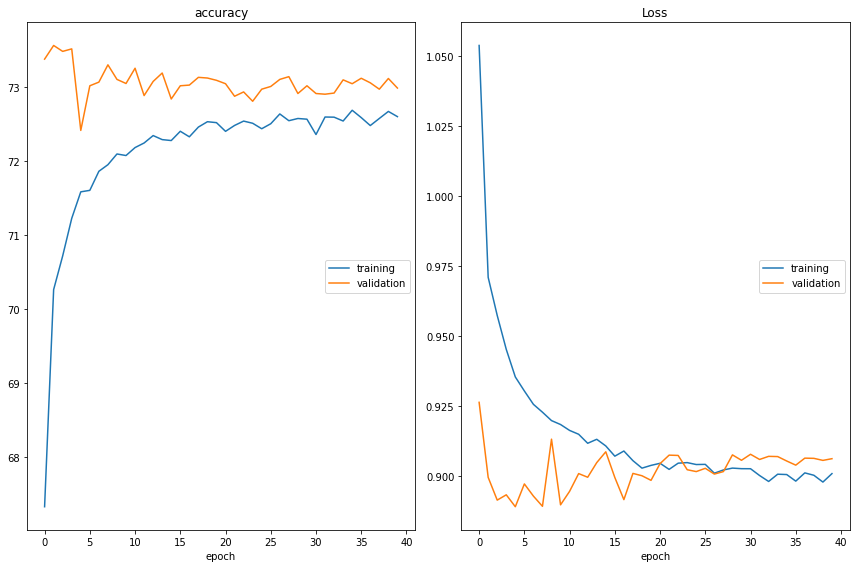

accuracy
	training         	 (min:   67.330, max:   72.682, cur:   72.596)
	validation       	 (min:   72.410, max:   73.557, cur:   72.982)
Loss
	training         	 (min:    0.898, max:    1.054, cur:    0.901)
	validation       	 (min:    0.889, max:    0.926, cur:    0.906)
Epoch 40/40


In [7]:
# helper function so set learning rate
def set_lr(lr):
  for param_group in optim.param_groups:
    param_group['lr'] = lr

epoch = 0
best_val_acc = -np.inf

while (epoch < n_epoch):
  epoch_loss = {}
  epoch_acc = {}
  for phase in ["train", "test"]:
    if phase == "train":
      model.train()
    else:
      model.eval()

    losses = 0
    correct = 0
    total = 0
  
    for batch_data, labels in dataloaders[phase]:
      batch_data, labels = batch_data.to(device), labels.to(device)

      if phase == "train":
        # stochastic frame sampling
        batch_data = torch.cat((batch_data[:, np.sort(np.random.choice([i for i in range(0,150)], 25, replace=False)), :], 
                              batch_data[:, np.sort(np.random.choice([i for i in range(150,240)], 18, replace=False)), :], 
                              batch_data[:, np.sort(np.random.choice([i for i in range(240,290)], 25, replace=False)), :], 
                              batch_data[:, 290:300, :]), dim=1)
      
        # batch normalization
        flat_data = batch_data.reshape(-1, batch_data.shape[-1])
      
        batch_means = torch.mean(flat_data, 0).view(1,1,-1)
        batch_stds = torch.std(flat_data, 0).view(1,1,-1)
        batch_stds = batch_stds.masked_fill(batch_stds == 0.0, 0.001)

        batch_data = (batch_data - batch_means) / batch_stds

        if torch.isnan(batch_data).any():
          print("error")
      
      output = model(batch_data)
      loss = nn.CrossEntropyLoss()(output.squeeze(), labels.long())

      # parameter update step
      if phase == "train":
        optim.zero_grad()
        loss.backward()
        optim.step()

      _, predicted = torch.max(output, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())
      losses += loss.item() * labels.shape[0]

    epoch_acc[phase] = 100*(correct / total)
    epoch_loss[phase] = losses / total

    if phase == "test" and epoch_acc[phase] > best_val_acc:
      best_val_acc = epoch_acc[phase]
      torch.save({'model':model.state_dict()}, 'drive/My Drive/training/LSTM1.chkpt')

  epoch += 1
  
  learning_rate *= lr_decay_rate
  set_lr(learning_rate)
  
  liveplot.update({"loss" : epoch_loss["train"], "val_loss" : epoch_loss["test"], "accuracy" : epoch_acc["train"], "val_accuracy" : epoch_acc["test"]})
  liveplot.send()
  print('Epoch {}/{}'.format(epoch, n_epoch))

**Model Validation**

In [8]:
try:
  params = torch.load('drive/My Drive/training/LSTM1.chkpt')
  model.load_state_dict(params['model'])
except:
  print('Failed to load best model ... using current model')

model.eval()

with torch.no_grad():
  for phase in ["train", "test"]:
    correct = 0
    total = 0
    for batch_data, labels in dataloaders[phase]:
      batch_data, labels = batch_data.to(device), labels.to(device).long()

      if phase == "train":
        # stochastic frame sampling
        batch_data = torch.cat((batch_data[:, np.sort(np.random.choice([i for i in range(0,150)], 25, replace=False)), :], 
                              batch_data[:, np.sort(np.random.choice([i for i in range(150,240)], 18, replace=False)), :], 
                              batch_data[:, np.sort(np.random.choice([i for i in range(240,290)], 25, replace=False)), :], 
                              batch_data[:, 290:300, :]), dim=1)

      output = model(batch_data)

      _, predicted = torch.max(output, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())

    print(f"Model ({phase}) accuracy: {100*(correct / total)}%")

Model (train) accuracy: 74.89099446587288%
Model (test) accuracy: 73.55671687672918%
